In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

In [2]:
train_df=pd.read_csv("/Users/Tim/Coding/CarInsuranceKaggle/Data/train.csv")
test_df=pd.read_csv("/Users/Tim/Coding/CarInsuranceKaggle/Data/test.csv")

## Prepare Data

In [3]:
variables=train_df.columns.values[2:]
print variables
halfsplit= len(train_df)/2
f1=train_df[variables].values[:halfsplit]
f2=train_df[variables].values[halfsplit:]
print f1.shape
print f2.shape
l1=train_df["target"][:halfsplit]
l2=train_df["target"][halfsplit:]
print l1.shape
print l2.shape

['ps_ind_01' 'ps_ind_02_cat' 'ps_ind_03' 'ps_ind_04_cat' 'ps_ind_05_cat'
 'ps_ind_06_bin' 'ps_ind_07_bin' 'ps_ind_08_bin' 'ps_ind_09_bin'
 'ps_ind_10_bin' 'ps_ind_11_bin' 'ps_ind_12_bin' 'ps_ind_13_bin'
 'ps_ind_14' 'ps_ind_15' 'ps_ind_16_bin' 'ps_ind_17_bin' 'ps_ind_18_bin'
 'ps_reg_01' 'ps_reg_02' 'ps_reg_03' 'ps_car_01_cat' 'ps_car_02_cat'
 'ps_car_03_cat' 'ps_car_04_cat' 'ps_car_05_cat' 'ps_car_06_cat'
 'ps_car_07_cat' 'ps_car_08_cat' 'ps_car_09_cat' 'ps_car_10_cat'
 'ps_car_11_cat' 'ps_car_11' 'ps_car_12' 'ps_car_13' 'ps_car_14'
 'ps_car_15' 'ps_calc_01' 'ps_calc_02' 'ps_calc_03' 'ps_calc_04'
 'ps_calc_05' 'ps_calc_06' 'ps_calc_07' 'ps_calc_08' 'ps_calc_09'
 'ps_calc_10' 'ps_calc_11' 'ps_calc_12' 'ps_calc_13' 'ps_calc_14'
 'ps_calc_15_bin' 'ps_calc_16_bin' 'ps_calc_17_bin' 'ps_calc_18_bin'
 'ps_calc_19_bin' 'ps_calc_20_bin']
(297606, 57)
(297606, 57)
(297606,)
(297606,)


## Train with some arbitrary parameters

In [4]:
dtrain=xgb.DMatrix( f1, label=l1)
dtest=xgb.DMatrix(f2, label=l2)
params = {'max_depth':2, 'eta':1, 'silent':0, 'objective':'binary:logistic' }
num_round = 2
xg1 = xgb.train(params, dtrain, num_round)

## TMVA Style response plot

In [5]:
test_scores=xg1.predict(dtest)

In [6]:
def ClassPlot(test_scores,labels):
    score=plt.figure("decision_tree_result")
    plot_range = (test_scores.min(), test_scores.max())
    plt.hist(test_scores[labels == 0],alpha=0.5,normed=True,range=plot_range)
    plt.hist(test_scores[labels == 1],alpha=0.5,normed=True,color='r',range=plot_range)
    plt.show()

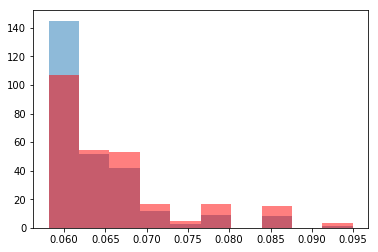

In [7]:
%matplotlib inline
ClassPlot(test_scores,l2)

## ROC Curve

In [8]:
from sklearn.metrics import classification_report, roc_auc_score 
from sklearn.metrics import roc_curve, auc
def ROCCurve(test_scores,labels):
    print "Area under ROC curve: %.4f"%(roc_auc_score(labels,test_scores))
    fpr, tpr, thresholds = roc_curve(l2, test_scores)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)'%(roc_auc))

    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

Area under ROC curve: 0.5851


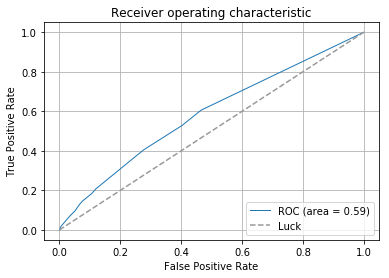

In [9]:
ROCCurve(test_scores,l2)

## Correlations

In [10]:
import numpy as np
def correlations(data, **kwds):
    """Calculate pairwise correlation between features.
    
    Extra arguments are passed on to DataFrame.corr()
    """
    # simply call df.corr() to get a table of
    # correlation values if you do not need
    # the fancy plotting
    corrmat = data.corr(**kwds)

    fig, ax1 = plt.subplots(ncols=1, figsize=(6,5))
    
    opts = {'cmap': plt.get_cmap("RdBu"),
            'vmin': -1, 'vmax': +1}
    heatmap1 = ax1.pcolor(corrmat, **opts)
    plt.colorbar(heatmap1, ax=ax1)

    ax1.set_title("Correlations")

    labels = corrmat.columns.values
    for ax in (ax1,):
        # shift location of ticks to center of the bins
        ax.set_xticks(np.arange(len(labels))+0.5, minor=False)
        ax.set_yticks(np.arange(len(labels))+0.5, minor=False)
        ax.set_xticklabels(labels, minor=False, ha='right', rotation=70)
        ax.set_yticklabels(labels, minor=False)
        
    plt.tight_layout()

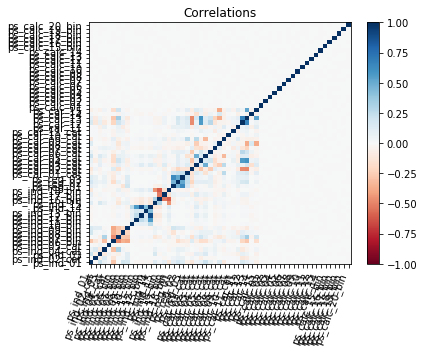

In [11]:
correlations(train_df[variables])

## Define metrics that the competition is judged by.

In [48]:
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)

def gini_xgb(preds, y):
    y = y.get_label()
    return 'gini', gini(y, preds) / gini(y, y)

In [54]:
forza_params = {'eta': 0.01, 'max_depth': 4, 'subsample': 0.9, 'colsample_bytree': 0.9, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'seed': 99, 'silent': True, 'n_estimators': 200}
params = {'max_depth':5 ,'eta':1.0, 'silent':0, 'n_estimators': [500],'objective':'binary:logistic' }
num_round = 100
watchlist = [(dtrain, 'train'), (dtest, 'valid')]
xg2 = xgb.train(forza_params, dtrain, num_round,watchlist, early_stopping_rounds=150, feval=gini_xgb)

Will train until valid error hasn't decreased in 150 rounds.
[0]	train-gini:0.198328	valid-gini:0.184640
[1]	train-gini:0.211978	valid-gini:0.197803
[2]	train-gini:0.219342	valid-gini:0.203608
[3]	train-gini:0.221437	valid-gini:0.205123
[4]	train-gini:0.221615	valid-gini:0.205248
[5]	train-gini:0.221634	valid-gini:0.205904
[6]	train-gini:0.227923	valid-gini:0.211941
[7]	train-gini:0.227668	valid-gini:0.211765
[8]	train-gini:0.227700	valid-gini:0.211204
[9]	train-gini:0.229950	valid-gini:0.212777
[10]	train-gini:0.229710	valid-gini:0.212476
[11]	train-gini:0.229284	valid-gini:0.211736
[12]	train-gini:0.228999	valid-gini:0.211484
[13]	train-gini:0.228738	valid-gini:0.211187
[14]	train-gini:0.230609	valid-gini:0.213046
[15]	train-gini:0.230612	valid-gini:0.212881
[16]	train-gini:0.231917	valid-gini:0.213828
[17]	train-gini:0.231485	valid-gini:0.213588
[18]	train-gini:0.232170	valid-gini:0.213942
[19]	train-gini:0.232088	valid-gini:0.213906
[20]	train-gini:0.233041	valid-gini:0.215274
[21]

In [55]:
xg2_scores=xg2.predict(dtest)

Area under ROC curve: 0.6158


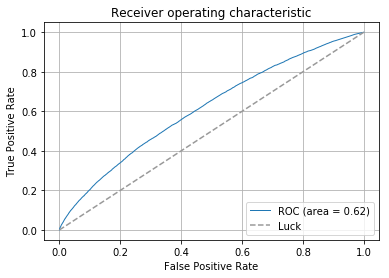

In [56]:
ROCCurve(xg2_scores,l2)

In [58]:
test_df["target"]=xg2.predict(xgb.DMatrix(test_df[variables]))

In [60]:
test_df[['id','target']].to_csv('submission.csv', index=False, float_format='%.5f')